# EM-ML Notebook

In **bold** are the parts to be configured

## **GDrive**

In [ ]:
ml_dir = 'Machine Learning for Vision and Multimedia'

proj_dir = '2'

## Drive mount

In [ ]:
import os
from google.colab import drive

drive_mount = '/content/drive'
drive.mount(drive_mount)
drive_path = os.path.join(drive_mount, 'MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
lab_path = os.path.join(drive_path, ml_dir, proj_dir)

## Imports

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from src.utils import count_parameters

## **Dataset**

1.   Load FashionMNIST
2.   Convert to tensor









In [53]:
data_path = os.path.join(lab_path, 'data')
download = not os.path.exists(data_path) or not os.listdir(data_path)

In [54]:
transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root=data_path, train=True, download=download, transform=transform)

3. Calculate mean and std dev

In [55]:
mean = train_dataset.data.float().mean()/255
std = train_dataset.data.float().std()/255

print(f"mean: {mean}")
print(f"stdev: {std}")

mean: 0.28604060411453247
stdev: 0.35244420170783997


4. Normalize the tensors


In [56]:
transform = transforms.Compose([transform, transforms.Normalize(mean, std)])

train_dataset = datasets.FashionMNIST(root=data_path, train=True, download=False, transform=transform)
test_dataset = datasets.FashionMNIST(root=data_path, train=True, download=download, transform=transform)

5. Random split Train: Train 90 - Val 10

In [57]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_dataset)}")

num_classes = 10

Training set size: 54000
Validation set size: 6000
Test set size: 10000


### Inspect

In [58]:
import math

id = math.floor(len(train_subset)/2)
image, label = train_subset[id]
print(f"Image {id} shape: {image.shape}")
print(f"Label {id}: {label}")

Image 27000 shape: torch.Size([1, 28, 28])
Label 27000: 3


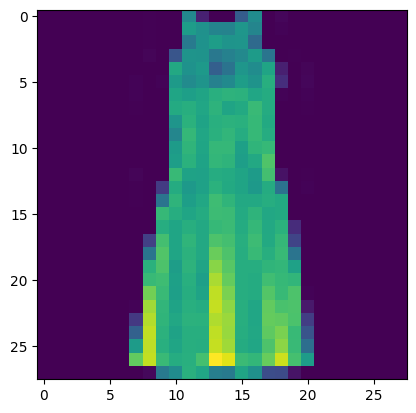

In [59]:
import matplotlib.pyplot as plt

plt.imshow(image[0].numpy())

## **Models**

In [92]:
class LinearFashion(nn.Module):
    def __init__(self, image_shape, n1, n2, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()

        self.lin1 = nn.Linear(image_shape[1]*image_shape[2], n1)
        self.act1 = nn.ReLU()

        self.lin2 = nn.Linear(n1, n2)
        self.act2 = nn.ReLU()

        self.output = nn.Linear(n2, num_classes)

    def forward(self, x):
        flat = self.flatten(x)

        l1 = self.lin1(flat)
        l1 = self.act1(l1)

        l2 = self.lin2(l1)
        l2 = self.act2(l2)

        logits = self.output(l2)
        return logits

class Convashion(nn.Module):
    def __init__(self, image_shape, c1, c2, n1, num_classes):
        super().__init__()

        # out size = (input size - kernel size + 2*padding) / stride + 1
        # default padding = 0, default stride conv = 1

        shape = np.array([image_shape[1], image_shape[2]])
        self.conv1 = nn.Conv2d(image_shape[0], c1, kernel_size=3) # (in-3)/1 + 1
        shape = (shape - 3) + 1
        self.pool1 = nn.MaxPool2d(kernel_size=2) # (in-2)/2 + 1 (stride = kernel_size)
        shape = (shape-2) / 2 + 1

        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3)
        shape = (shape-3) + 1
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        shape = (shape-2) / 2 + 1

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(c2 * math.floor(shape[0]) * math.floor(shape[1]), n1)
        self.fc2 = nn.Linear(n1, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    # conv1 = (3x3 + 1) * 64 = 640   (bias is a scalar, not a matrix)
    # conv2 = (3x3x64 + 1) * 128 = 73856  (kernel is now a tensor, not a matrix)
    # fc1 = (128x5x5 + 1) * 128 = 409728   (5*5 = shape after pool2)
    # fc2 = (128+1)*10 = 1280
    # tot = 485514

## **Hyperparams**

Define configurations

In [93]:
models = {
    'linear1': LinearFashion(image.shape, 512, 256, num_classes),
    'convashion1': Convashion(image.shape, 64, 128, 128, num_classes)
}

In [ ]:
from src.configs import ConfigManager

configs = ConfigManager()

configs.add('linear1', models['linear1'], 
            F.cross_entropy, optim.SGD(models['linear1'].parameters(), lr=0.01, momentum=0.9), 
            batch_size=100, epochs=30)

configs.add('convashion1', models['convashion1'], 
            F.cross_entropy, optim.Adam(models['convashion1'].parameters(), lr=0.01, weight_decay=0.01), 
            batch_size=100, epochs=30)

Choose config

In [ ]:
configs.activate('convashion1')

## Dataloader

In [ ]:
batch_size = configs.active['batch_size']

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_batches = int(len(train_dataset)/batch_size)
print(f"Batch size: {batch_size}")
print(f"Num batches: {num_batches}")

Batch size: 100
Num batches: 600


## Training

Device select

In [ ]:
from src.trainer import Trainer

trainer = Trainer(configs.active)

Using device: cpu


Load previous checkpoint state (optional)

In [ ]:
trainer.restore_checkpoint()

## **Train**

In [ ]:
print("Training...\n")

trainer.train_loop(train_loader, val_loader)

Training...

Train Epoch: 2 [s 1/54000 b 1/600 (0%)]	Loss: 0.477931
Train Epoch: 2 [s 10001/54000 b 101/600 (19%)]	Loss: 0.466211
Train Epoch: 2 [s 20001/54000 b 201/600 (37%)]	Loss: 0.478728
Train Epoch: 2 [s 30001/54000 b 301/600 (56%)]	Loss: 0.381164
Train Epoch: 2 [s 40001/54000 b 401/600 (74%)]	Loss: 0.364053
Train Epoch: 2 [s 50001/54000 b 501/600 (93%)]	Loss: 0.402381
Eval average loss: 0.4403, Accuracy: 83.6667%
Validation loss decreased: 0.4837840115229289 ----> 0.4402729962666829 , Accuracy: 83.667% , Saving Model...
Train Epoch: 3 [s 1/54000 b 1/600 (0%)]	Loss: 0.420720
Train Epoch: 3 [s 10001/54000 b 101/600 (19%)]	Loss: 0.625148
Train Epoch: 3 [s 20001/54000 b 201/600 (37%)]	Loss: 0.458008


KeyboardInterrupt: 

## **Test**

In [ ]:
print("Test\n")

trainer.test(test_loader)

Test

Eval average loss: 0.4665, Accuracy: 82.8400%


(0.4664905406951904, 82.84)